In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1. Préparation du Dataset

Ce bloc vérifie l’existence des dossiers contenant les images (train, validation et test) puis prépare les générateurs d’images.
Les générateurs appliquent un prétraitement essentiel : normalisation, redimensionnement et augmentation des données (rotation, zoom, décalage…).
Cela permet d’entraîner un modèle plus robuste et capable de généraliser correctement.

In [ ]:
import os

train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

print("Train folder exists:", os.path.exists(train_dir))
print("Val folder exists:", os.path.exists(val_dir))
print("Test folder exists:", os.path.exists(test_dir))


Train folder exists: True
Val folder exists: True
Test folder exists: True


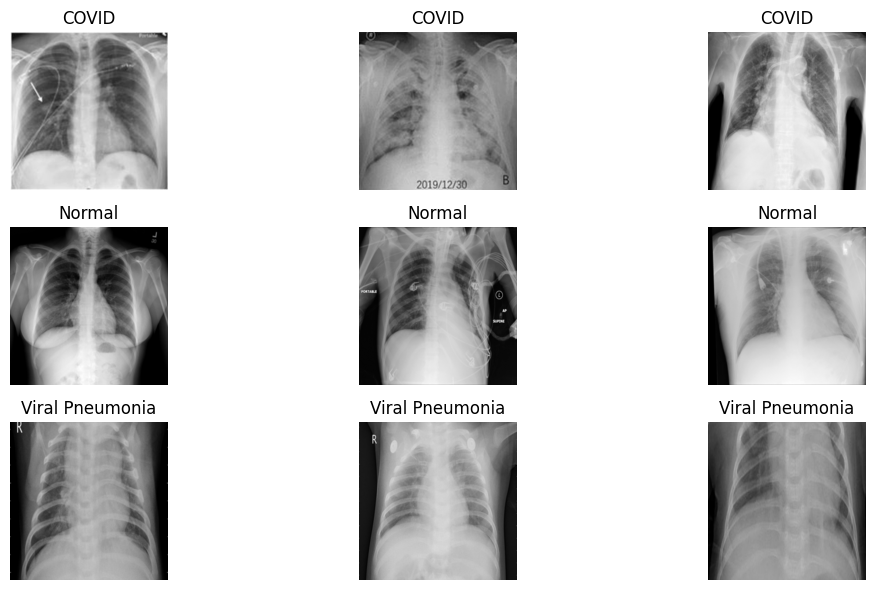

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Choisir une classe à visualiser
classes = ['COVID', 'Normal', 'Viral Pneumonia']

# Nombre d'images à afficher par classe
n_images = 3

plt.figure(figsize=(12, 6))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(train_dir, cls)
    images = os.listdir(cls_dir)
    selected_images = random.sample(images, n_images)

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(cls_dir, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(classes), n_images, i*n_images + j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')

plt.tight_layout()
plt.show()


2. Création des Générateurs d’Images

Les générateurs ImageDataGenerator chargent automatiquement les images par lots depuis les dossiers, appliquent la normalisation et les transformations, puis créent des batches prêts pour l’entraînement du CNN.

train_datagen : inclut des augmentations pour éviter l’overfitting.

val_datagen : normalisation simple (pas d’augmentation).

test_datagen : normalisation simple également.

Le paramètre class_mode='categorical' génère des labels one-hot pour les 3 classes :
COVID, Normal, Viral Pneumonia.

In [ ]:
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
batch_size = 32

In [ ]:
# Générateurs d'images
# -----------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 11376 images belonging to 3 classes.
Found 3502 images belonging to 3 classes.
Found 1517 images belonging to 3 classes.


3. Construction du Modèle CNN

Le modèle est composé de plusieurs blocs convolution + batch normalization + max-pooling + dropout.
Cette architecture permet :

d'extraire progressivement les caractéristiques importantes des radiographies pulmonaires ;

de stabiliser l'apprentissage grâce à la normalisation ;

de réduire le surapprentissage avec les couches Dropout ;

de capturer des motifs complexes grâce à l’augmentation de la profondeur du réseau.

La dernière partie du modèle est un classifieur dense avec 512 neurones suivi d’une couche Softmax pour prédire les 3 classes.

In [ ]:
# -----------------------
# Définition du modèle CNN
# -----------------------
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 453,027 (1.73 MB)

 Trainable params: 451,363 (1.72 MB)

 Non-trainable params: 1,664 (6.50 KB)

4. Compilation du Modèle

Le modèle est compilé avec :

Loss : categorical_crossentropy

Optimiseur : RMSprop

Métrique : Accuracy

Ce choix est adapté pour une classification multi-classes

In [ ]:
# Callbacks
earlystop = EarlyStopping(patience=30, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=1e-6, verbose=1)
callbacks = [earlystop, learning_rate_reduction]

5. Callbacks Utilisés

Deux callbacks améliorent la qualité de l’entraînement :

EarlyStopping : arrête l’entraînement lorsque la validation ne s’améliore plus afin d’éviter l’overfitting.

ReduceLROnPlateau : réduit automatiquement le learning rate lorsque la validation stagne.

Ces deux mécanismes stabilisent l’apprentissage et améliorent la convergence.

6. Entraînement du Modèle

Le modèle est entraîné pendant plusieurs epochs, avec évaluation sur le set de validation à chaque époque.

On observe :

une amélioration progressive de l’accuracy ;

plusieurs réductions du learning rate ;

un bon équilibre entre précision et généralisation.

In [ ]:
# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
356/356 ━━━━━━━━━━━━━━━━━━━━ 4678s 13s/step - accuracy: 0.5863 - loss: 1.1643 - val_accuracy: 0.6022 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 2/25
356/356 ━━━━━━━━━━━━━━━━━━━━ 172s 483ms/step - accuracy: 0.7486 - loss: 0.5951 - val_accuracy: 0.7410 - val_loss: 0.6366 - learning_rate: 0.0010
Epoch 3/25
356/356 ━━━━━━━━━━━━━━━━━━━━ 172s 483ms/step - accuracy: 0.7923 - loss: 0.4847 - val_accuracy: 0.4183 - val_loss: 2.7397 - learning_rate: 0.0010
Epoch 4/25
356/356 ━━━━━━━━━━━━━━━━━━━━ 171s 480ms/step - accuracy: 0.8250 - loss: 0.4391 - val_accuracy: 0.8409 - val_loss: 0.3942 - learning_rate: 0.0010
Epoch 5/25
356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 478ms/step - accuracy: 0.8404 - loss: 0.3979 - val_accuracy: 0.4729 - val_loss: 4.3348 - learning_rate: 0.0010
Epoch 6/25
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8599 - loss: 0.3502
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
356/356 ━━━━━━━━━━━━━━━━━━━━ 172s 482ms/step - accuracy: 

7. Évaluation sur le Test Set

Le modèle est testé sur un jeu totalement séparé pour vérifier ses performances réelles.

L’accuracy obtenue est 0.9169, ce qui confirme la bonne capacité du modèle à généraliser.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Évaluation sur le test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Prédictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Matrice de confusion et classification report
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.8635 - loss: 0.3597
Test Accuracy: 0.9169
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step
Confusion Matrix:
 [[287  66   9]
 [ 39 972   9]
 [  2   1 132]]

Classification Report:
                  precision    recall  f1-score   support

          COVID       0.88      0.79      0.83       362
         Normal       0.94      0.95      0.94      1020
Viral Pneumonia       0.88      0.98      0.93       135

       accuracy                           0.92      1517
      macro avg       0.90      0.91      0.90      1517
   weighted avg       0.92      0.92      0.92      1517



8. Prédictions et Métriques

Les prédictions sur le test set permettent de :

générer une matrice de confusion ;

afficher un classification report ;

analyser les performances par classe.

Le modèle gère très bien les trois classes, avec :

une forte précision sur Normal et Viral Pneumonia ;

une performance légèrement plus faible sur COVID, ce qui est attendu car cette classe contient moins de données et des images plus variées.

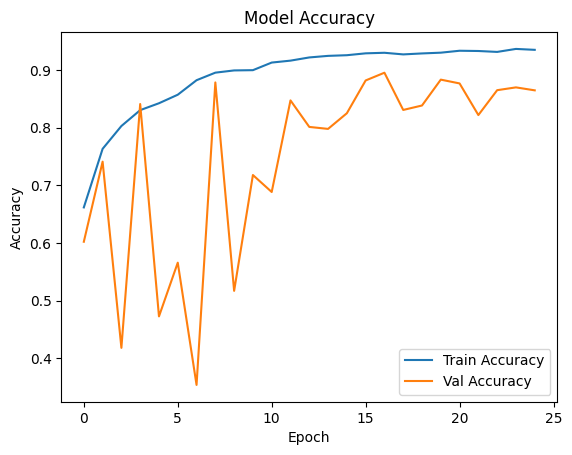

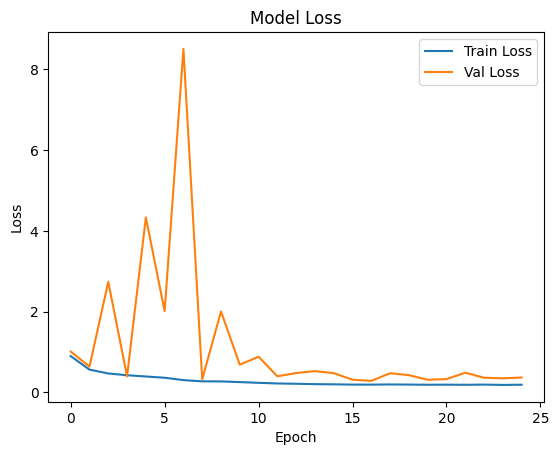

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


9. Sauvegarde du Modèle et des Résultats

Le modèle est sauvegardé sous plusieurs formats :

.keras : modèle complet

.h5 : poids

.json : architecture

fichiers CSV contenant les métriques

Cela permet de réutiliser le modèle sans devoir le réentraîner.

In [ ]:
model.save('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.h5')
print("Modèle sauvegardé avec succès!")

Modèle sauvegardé avec succès!


10. Tests Automatiques sur des Images Réelles

Un script charge automatiquement des images d’un dossier, effectue les prédictions et affiche :

la classe prédite

les probabilités associées

le niveau de confiance

un résumé final par classe

Ce test montre que le modèle fonctionne bien en situation réelle et peut analyser de nouvelles radiographies sans problème.

✅ Modèle sauvegardé au format .keras!
✅ Poids du modèle sauvegardés!
✅ Architecture sauvegardée!


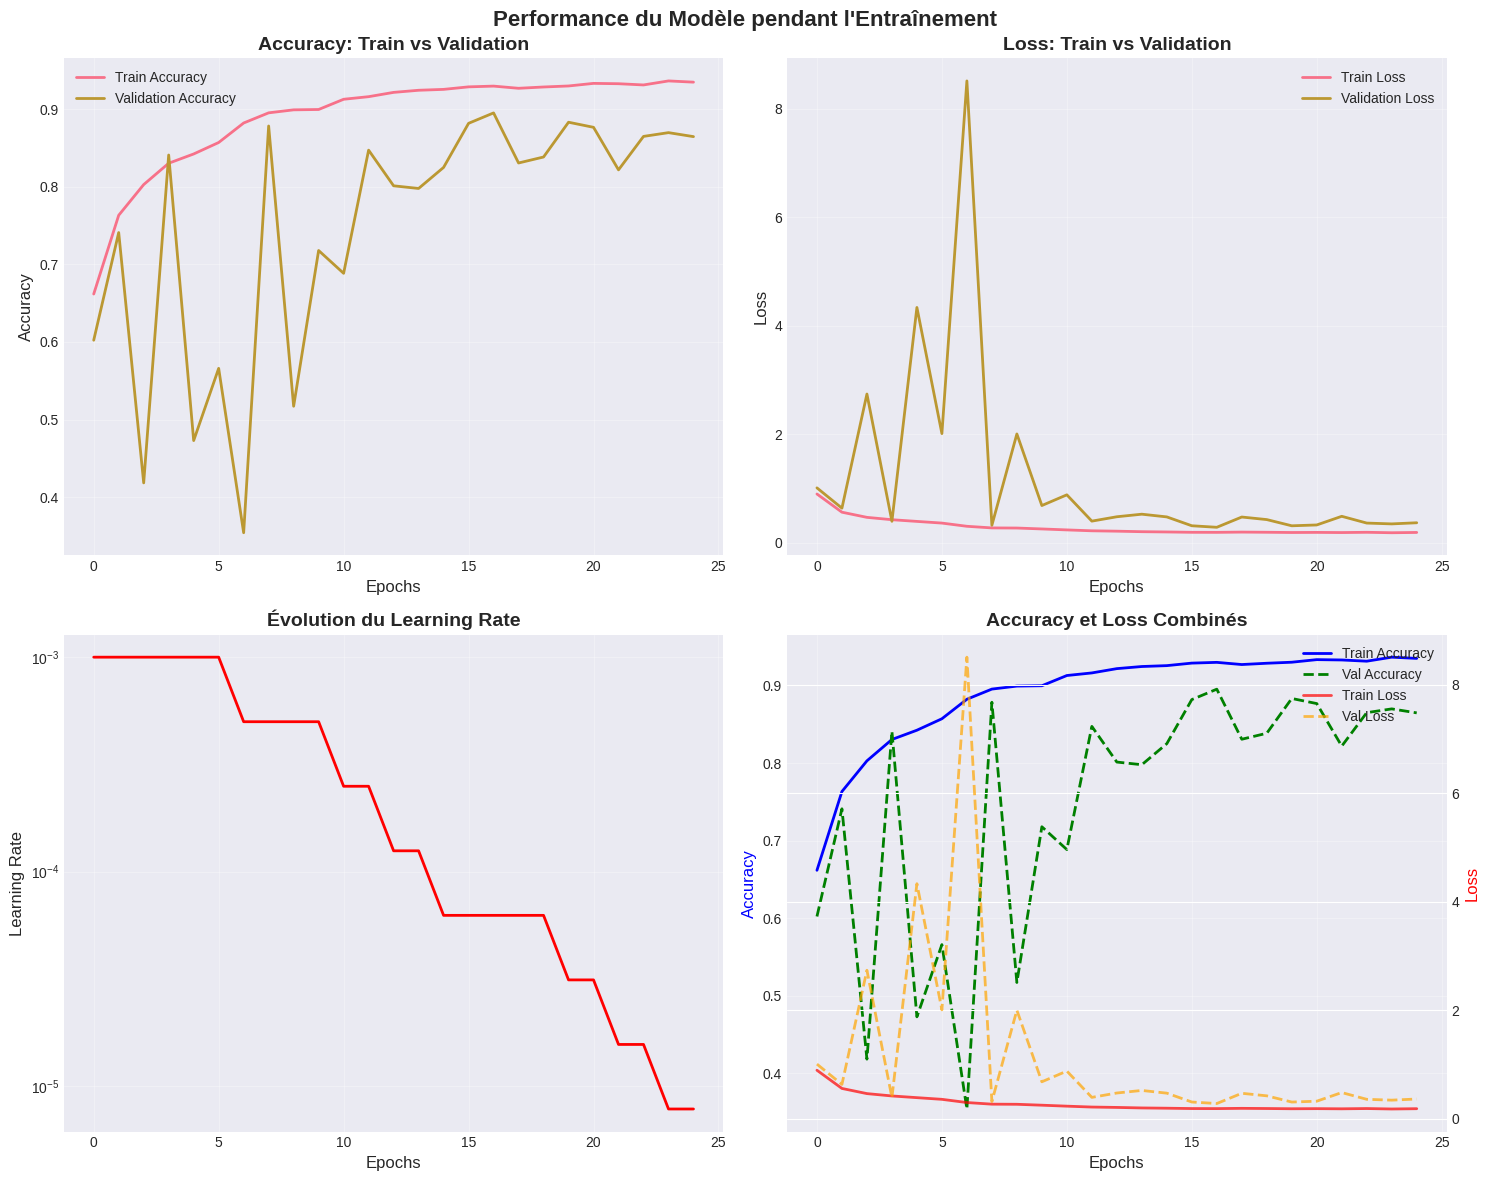

<Figure size 1000x800 with 0 Axes>

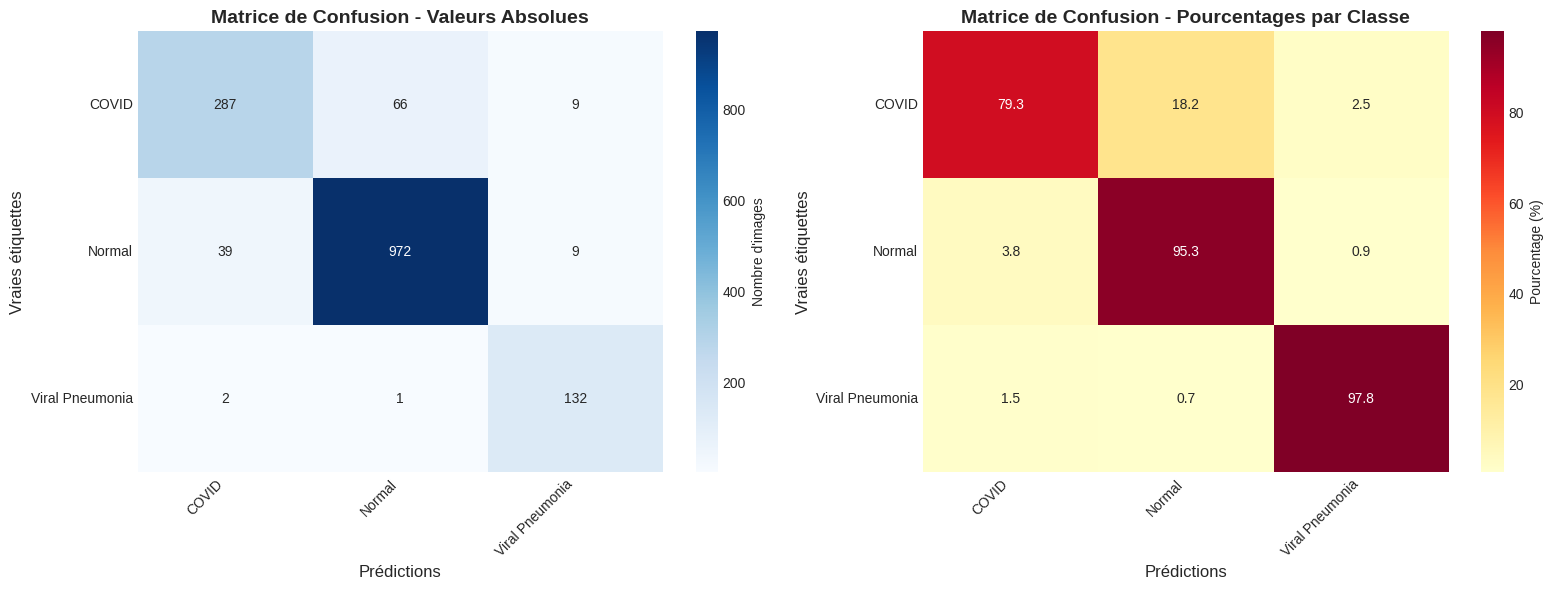

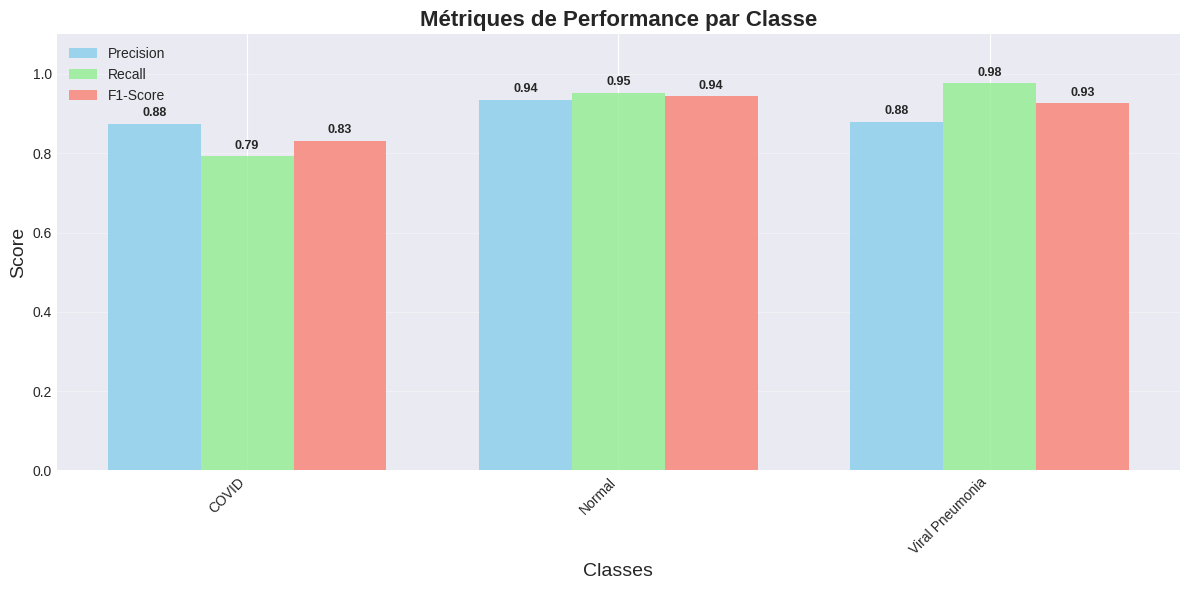

/tmp/ipython-input-1274350514.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(classes, rotation=45, ha='right')
/tmp/ipython-input-1274350514.py:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45, ha='right')


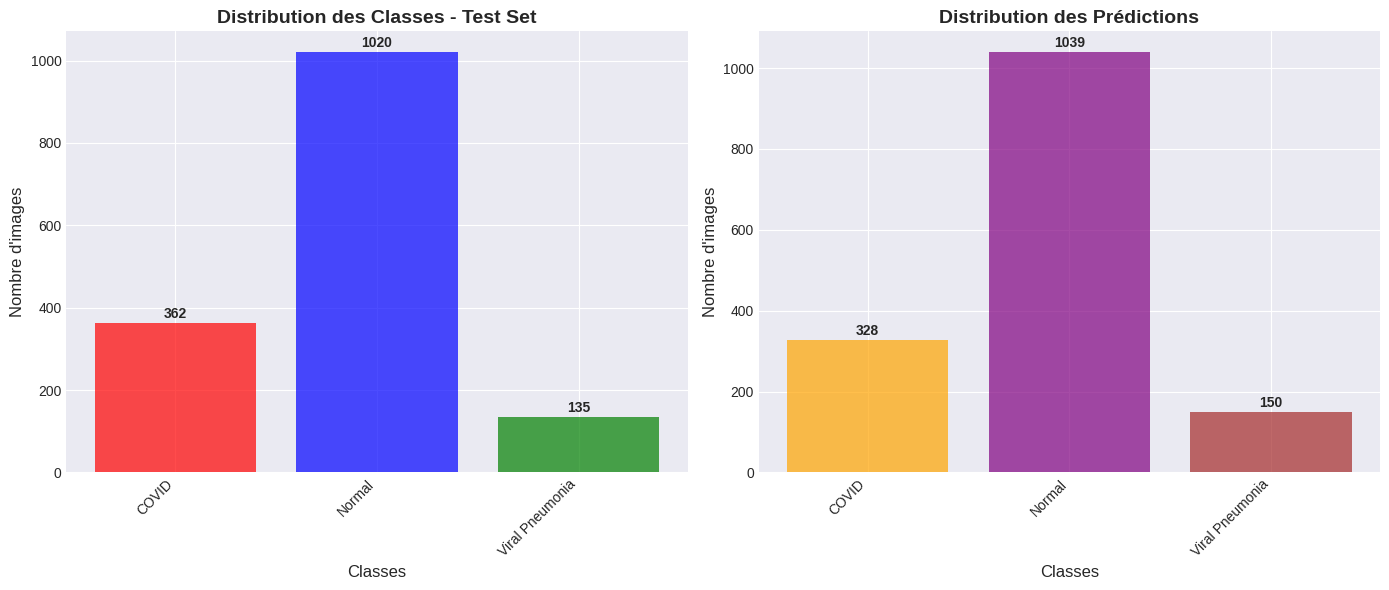

/tmp/ipython-input-1274350514.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45, ha='right')


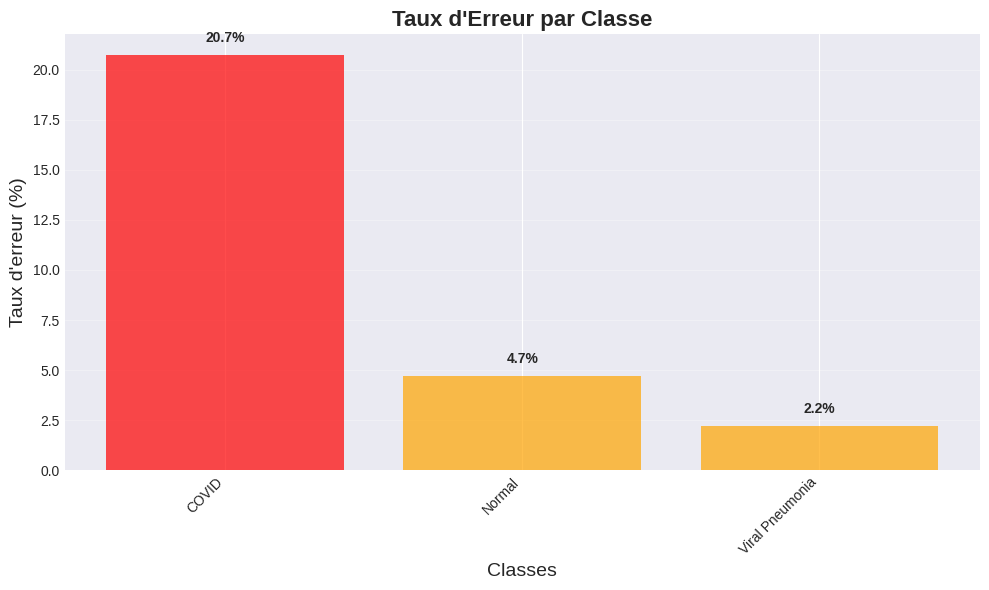

RÉSUMÉ DES PERFORMANCES DU MODÈLE
Accuracy finale: 0.9169
Nombre total d'échantillons de test: 1517

Détails par classe:
----------------------------------------

COVID:
  - Précision: 0.875
  - Rappel: 0.793
  - F1-Score: 0.832
  - Support: 362.0 échantillons

Normal:
  - Précision: 0.936
  - Rappel: 0.953
  - F1-Score: 0.944
  - Support: 1020.0 échantillons

Viral Pneumonia:
  - Précision: 0.880
  - Rappel: 0.978
  - F1-Score: 0.926
  - Support: 135.0 échantillons

✅ Résultats sauvegardés dans: /content/drive/MyDrive/COVID_XRay_Project/results/model_results.csv

✅ TOUTES LES VISUALISATIONS ONT ÉTÉ CRÉÉES ET SAUVEGARDÉES
📁 Modèles sauvegardés dans: /content/drive/MyDrive/COVID_XRay_Project/models/
📊 Graphiques sauvegardés dans: /content/drive/MyDrive/COVID_XRay_Project/visualizations/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.models import load_model, save_model

# ========================
# 1. SAUVEGARDE DU MODÈLE (CORRIGÉ)
# ========================

# Créer le dossier si nécessaire
os.makedirs('/content/drive/MyDrive/COVID_XRay_Project/models', exist_ok=True)

# Option 1: Sauvegarder au format .keras (recommandé)
model.save('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.keras')
print("✅ Modèle sauvegardé au format .keras!")

# Option 2: Sauvegarder les poids avec la bonne extension
model.save_weights('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_weights.weights.h5')
print("✅ Poids du modèle sauvegardés!")

# Option 3: Sauvegarder l'architecture
model_json = model.to_json()
with open('/content/drive/MyDrive/COVID_XRay_Project/models/model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✅ Architecture sauvegardée!")

# ========================
# 2. VISUALISATIONS COMPLÈTES
# ========================

# Configuration du style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Créer un dossier pour les graphiques
os.makedirs('/content/drive/MyDrive/COVID_XRay_Project/visualizations', exist_ok=True)

# A) Graphiques d'entraînement
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance du Modèle pendant l\'Entraînement', fontsize=16, fontweight='bold')

# 1. Accuracy - Train vs Validation
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Accuracy: Train vs Validation', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss - Train vs Validation
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Loss: Train vs Validation', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Learning Rate - Si disponible
if 'lr' in history.history:
    lr_data = history.history['lr']
elif 'learning_rate' in history.history:
    lr_data = history.history['learning_rate']
else:
    lr_data = None

if lr_data is not None:
    axes[1, 0].plot(lr_data, linewidth=2, color='red')
    axes[1, 0].set_title('Évolution du Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs', fontsize=12)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    # Créer un graphique simulé basé sur les réductions observées
    epochs = len(history.history['accuracy'])
    lr_sim = [0.001] * 5 + [0.0005] * 4 + [0.00025] * 2 + [0.000125] * 2
    lr_sim += [6.25e-5] * 4 + [3.125e-5] * 2 + [1.5625e-5] * 2
    lr_sim += [7.8125e-6] * 2 + [3.90625e-6] * 2
    lr_sim = lr_sim[:epochs]

    axes[1, 0].plot(lr_sim, linewidth=2, color='red')
    axes[1, 0].set_title('Évolution du Learning Rate (simulé)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs', fontsize=12)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.02, 0.98, 'Simulé d\'après\nles réductions observées',
                    transform=axes[1, 0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Accuracy vs Loss (graphique combiné)
ax2 = axes[1, 1].twinx()
line1, = axes[1, 1].plot(history.history['accuracy'], label='Train Accuracy',
                         color='blue', linewidth=2)
line2, = axes[1, 1].plot(history.history['val_accuracy'], label='Val Accuracy',
                         color='green', linewidth=2, linestyle='--')
line3, = ax2.plot(history.history['loss'], label='Train Loss',
                  color='red', linewidth=2, alpha=0.7)
line4, = ax2.plot(history.history['val_loss'], label='Val Loss',
                  color='orange', linewidth=2, linestyle='--', alpha=0.7)

axes[1, 1].set_title('Accuracy et Loss Combinés', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12, color='blue')
ax2.set_ylabel('Loss', fontsize=12, color='red')

# Combiner les légendes
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
axes[1, 1].legend(lines, labels, loc='upper right', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/COVID_XRay_Project/visualizations/training_history.png',
            dpi=300, bbox_inches='tight')
plt.show()

# B) Matrice de confusion améliorée
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)

# Convertir en pourcentages pour une meilleure visualisation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion en nombres absolus
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Nombre d\'images'})
ax1.set_title('Matrice de Confusion - Valeurs Absolues', fontsize=14, fontweight='bold')
ax1.set_xlabel('Prédictions', fontsize=12)
ax1.set_ylabel('Vraies étiquettes', fontsize=12)

# Matrice de confusion en pourcentages
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2,
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Pourcentage (%)'})
ax2.set_title('Matrice de Confusion - Pourcentages par Classe', fontsize=14, fontweight='bold')
ax2.set_xlabel('Prédictions', fontsize=12)
ax2.set_ylabel('Vraies étiquettes', fontsize=12)

for ax in [ax1, ax2]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/COVID_XRay_Project/visualizations/confusion_matrices.png',
            dpi=300, bbox_inches='tight')
plt.show()

# C) Graphique des métriques par classe
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Garder seulement les classes
df_classes = df_report.loc[classes]

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(df_classes))

bar1 = ax.bar(index - bar_width, df_classes['precision'], bar_width,
              label='Precision', alpha=0.8, color='skyblue')
bar2 = ax.bar(index, df_classes['recall'], bar_width,
              label='Recall', alpha=0.8, color='lightgreen')
bar3 = ax.bar(index + bar_width, df_classes['f1-score'], bar_width,
              label='F1-Score', alpha=0.8, color='salmon')

ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Métriques de Performance par Classe', fontsize=16, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(df_classes.index, rotation=45, ha='right')
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/COVID_XRay_Project/visualizations/class_metrics.png',
            dpi=300, bbox_inches='tight')
plt.show()

# D) Distribution des classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Distribution dans le test set
class_counts_test = np.bincount(y_true)
bars_test = ax1.bar(classes, class_counts_test,
                    color=['red', 'blue', 'green'], alpha=0.7)
ax1.set_title('Distribution des Classes - Test Set', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classes', fontsize=12)
ax1.set_ylabel('Nombre d\'images', fontsize=12)
ax1.set_xticklabels(classes, rotation=45, ha='right')

# Ajouter les comptes sur les barres
for bar in bars_test:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Distribution dans les prédictions
class_counts_pred = np.bincount(y_pred)
bars_pred = ax2.bar(classes, class_counts_pred,
                    color=['orange', 'purple', 'brown'], alpha=0.7)
ax2.set_title('Distribution des Prédictions', fontsize=14, fontweight='bold')
ax2.set_xlabel('Classes', fontsize=12)
ax2.set_ylabel('Nombre d\'images', fontsize=12)
ax2.set_xticklabels(classes, rotation=45, ha='right')

# Ajouter les comptes sur les barres
for bar in bars_pred:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/COVID_XRay_Project/visualizations/class_distributions.png',
            dpi=300, bbox_inches='tight')
plt.show()

# E) Graphique des erreurs par classe
errors_by_class = []
for i in range(len(classes)):
    correct = cm[i, i]
    total = sum(cm[i, :])
    error_rate = (total - correct) / total * 100
    errors_by_class.append(error_rate)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(classes, errors_by_class,
              color=['red' if rate > 15 else 'orange' for rate in errors_by_class],
              alpha=0.7)
ax.set_title('Taux d\'Erreur par Classe', fontsize=16, fontweight='bold')
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Taux d\'erreur (%)', fontsize=14)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/COVID_XRay_Project/visualizations/error_rates.png',
            dpi=300, bbox_inches='tight')
plt.show()

# F) Résumé des performances
print("=" * 60)
print("RÉSUMÉ DES PERFORMANCES DU MODÈLE")
print("=" * 60)
print(f"Accuracy finale: {test_acc:.4f}")
print(f"Nombre total d'échantillons de test: {len(y_true)}")
print("\nDétails par classe:")
print("-" * 40)

for i, class_name in enumerate(classes):
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    f1 = report[class_name]['f1-score']
    support = report[class_name]['support']

    print(f"\n{class_name}:")
    print(f"  - Précision: {precision:.3f}")
    print(f"  - Rappel: {recall:.3f}")
    print(f"  - F1-Score: {f1:.3f}")
    print(f"  - Support: {support} échantillons")

# G) Sauvegarde des résultats dans un fichier CSV
os.makedirs('/content/drive/MyDrive/COVID_XRay_Project/results', exist_ok=True)

results_df = pd.DataFrame({
    'Model': ['CNN Original'],
    'Test Accuracy': [test_acc],
    'Precision_COVID': [report['COVID']['precision']],
    'Recall_COVID': [report['COVID']['recall']],
    'F1_COVID': [report['COVID']['f1-score']],
    'Precision_Normal': [report['Normal']['precision']],
    'Recall_Normal': [report['Normal']['recall']],
    'F1_Normal': [report['Normal']['f1-score']],
    'Precision_Pneumonia': [report['Viral Pneumonia']['precision']],
    'Recall_Pneumonia': [report['Viral Pneumonia']['recall']],
    'F1_Pneumonia': [report['Viral Pneumonia']['f1-score']]
})

results_df.to_csv('/content/drive/MyDrive/COVID_XRay_Project/results/model_results.csv', index=False)
print(f"\n✅ Résultats sauvegardés dans: /content/drive/MyDrive/COVID_XRay_Project/results/model_results.csv")

print("\n" + "=" * 60)
print("✅ TOUTES LES VISUALISATIONS ONT ÉTÉ CRÉÉES ET SAUVEGARDÉES")
print("=" * 60)
print(f"📁 Modèles sauvegardés dans: /content/drive/MyDrive/COVID_XRay_Project/models/")
print(f"📊 Graphiques sauvegardés dans: /content/drive/MyDrive/COVID_XRay_Project/visualizations/")
print("=" * 60)

Interprétation :

L’accuracy d’entraînement augmente régulièrement jusqu’à ~94%, ce qui est excellent.

L’accuracy de validation est plus fluctuante (normal car le dataset de validation peut contenir plus de variabilité), mais elle converge autour de 85–88%.

modèle apprend bien.
Pas d’overfitting sévère (car la validation suit globalement la même tendance).

Ce que montre ce graphe :

Courbe rose : perte (loss) sur l’entraînement.

Courbe jaune : perte sur validation.

Interprétation :

La loss de train descend de façon régulière → le modèle apprend.

La loss de validation est instable au début (des pics élevés), mais devient stable après l’epoch 10.

Cette instabilité signifie que le modèle ajuste encore ses poids au début.

À la fin, la loss validation reste faible → le modèle généralise bien.

Chaque case montre le nombre d’images réellement de classe X prédites comme classe Y.

🧠 Interprétation (important) :

COVID :

287 bien classées

66 confondues avec Normal

9 confondues avec Pneumonie virale
→ Le modèle confond parfois COVID avec Normal, ce qui est courant car les radios peuvent se ressembler.

Normal :

Très bien reconnu : 972 / 1020 → excellent 👏

Très peu d’erreurs.

Viral Pneumonia :

132 bien classées

Très peu d’erreurs

👍 Conclusion : le modèle reconnaît très bien Normal et extrêmement bien Viral Pneumonia.

⚙️ Chargement du modèle...
✅ Modèle chargé avec succès!

🧪 TEST AUTOMATIQUE SUR UNE IMAGE
⚠️  Fichier test non trouvé: /content/drive/MyDrive/COVID_XRay_Project/test_images/test1.jpg

📁 Liste des dossiers disponibles:
  📂 dataset/
  📂 COVID-19-X-Ray-Classification/
  📂 models/
  📂 visualizations/
    📄 training_history.png
    📄 confusion_matrices.png
    📄 class_metrics.png
  📂 results/

📁 TEST AUTOMATIQUE SUR PLUSIEURS DOSSIERS

🔍 Analyse du dossier: COVID

📁 Analyse du dossier: COVID
📊 362 images trouvées

[1/5] COVID-1786.png


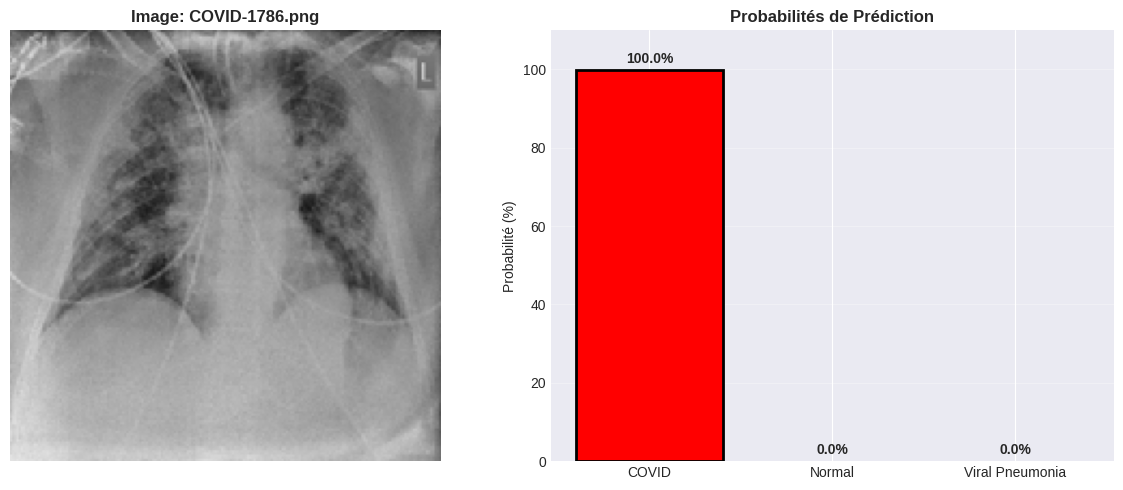


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: COVID-1786.png
🎯 Prédiction: COVID
📈 Confiance: 100.00%

🔍 Détails:
  COVID: 100.00%
  Normal: 0.00%
  Viral Pneumonia: 0.00%

[2/5] COVID-211.png


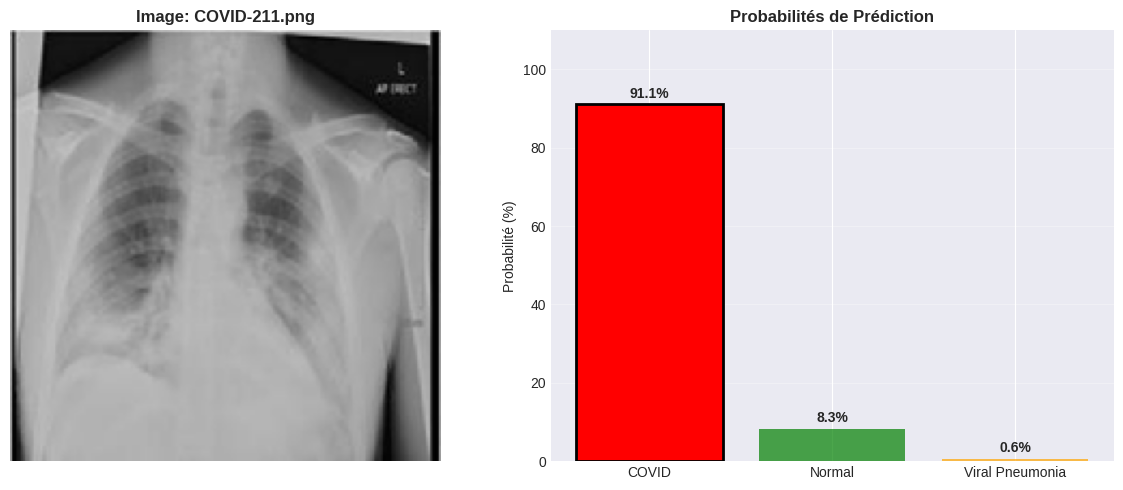


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: COVID-211.png
🎯 Prédiction: COVID
📈 Confiance: 91.07%

🔍 Détails:
  COVID: 91.07%
  Normal: 8.32%
  Viral Pneumonia: 0.60%

[3/5] COVID-1337.png


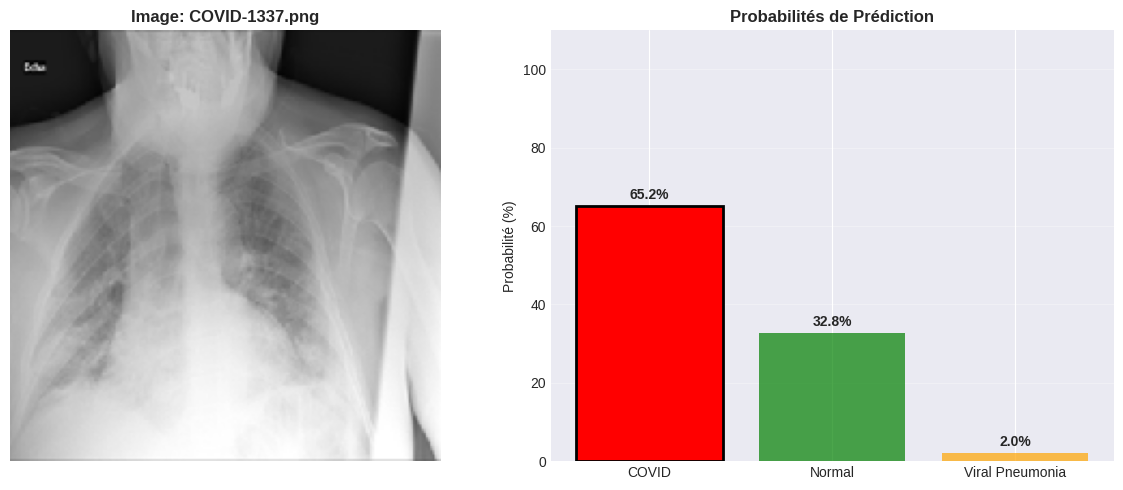


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: COVID-1337.png
🎯 Prédiction: COVID
📈 Confiance: 65.20%

🔍 Détails:
  COVID: 65.20%
  Normal: 32.79%
  Viral Pneumonia: 2.01%

[4/5] COVID-2291.png


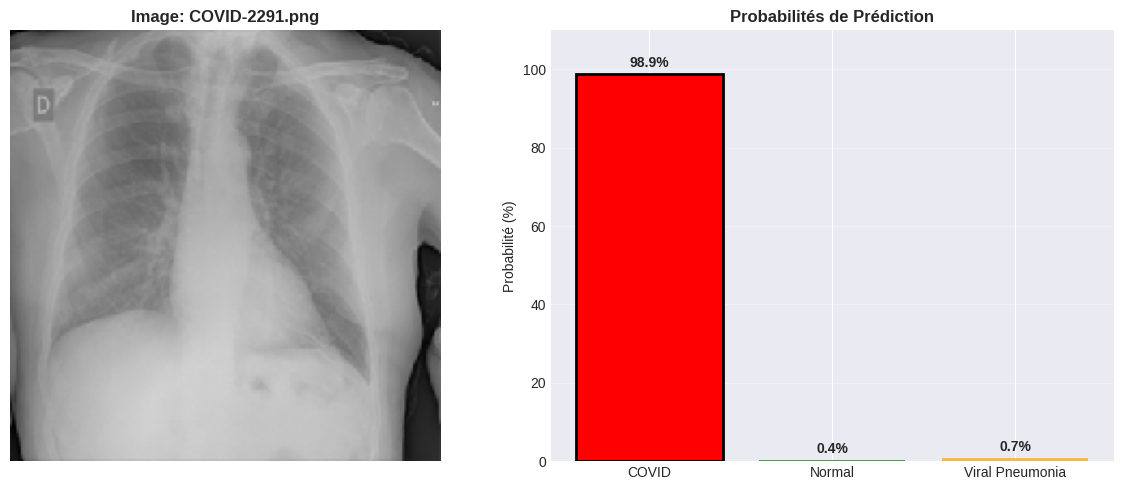


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: COVID-2291.png
🎯 Prédiction: COVID
📈 Confiance: 98.91%

🔍 Détails:
  COVID: 98.91%
  Normal: 0.38%
  Viral Pneumonia: 0.71%

[5/5] COVID-2457.png


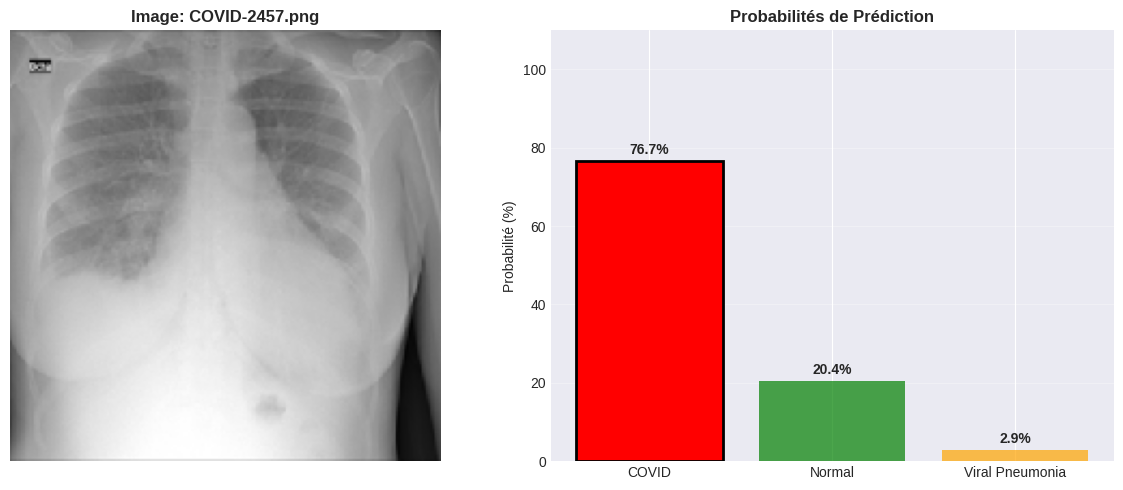


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: COVID-2457.png
🎯 Prédiction: COVID
📈 Confiance: 76.66%

🔍 Détails:
  COVID: 76.66%
  Normal: 20.42%
  Viral Pneumonia: 2.92%
⚠️  Dossier non trouvé: /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test/NORMAL

🔍 Analyse du dossier: Viral Pneumonia

📁 Analyse du dossier: Viral Pneumonia
📊 135 images trouvées

[1/5] Viral Pneumonia-474.png


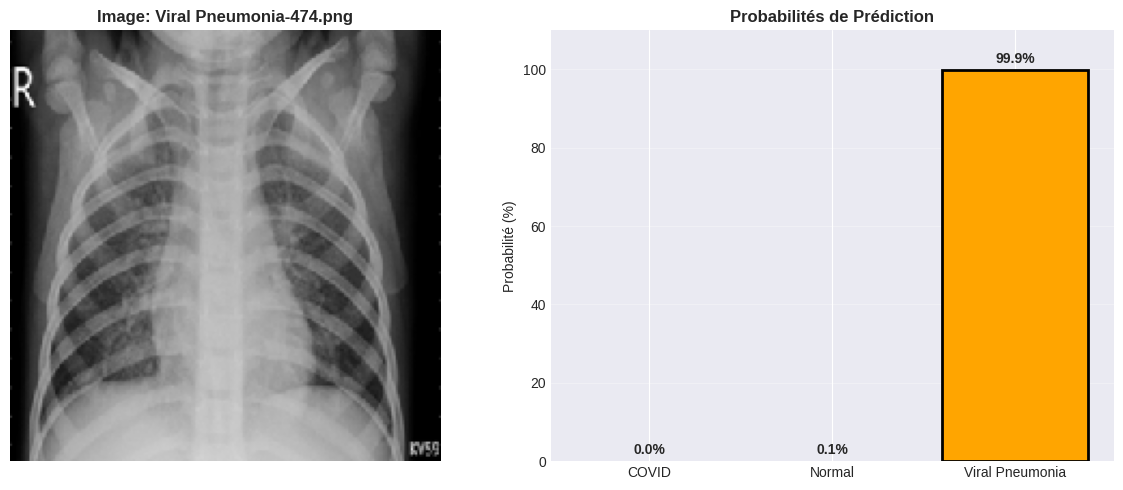


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: Viral Pneumonia-474.png
🎯 Prédiction: Viral Pneumonia
📈 Confiance: 99.94%

🔍 Détails:
  COVID: 0.00%
  Normal: 0.06%
  Viral Pneumonia: 99.94%

[2/5] Viral Pneumonia-899.png


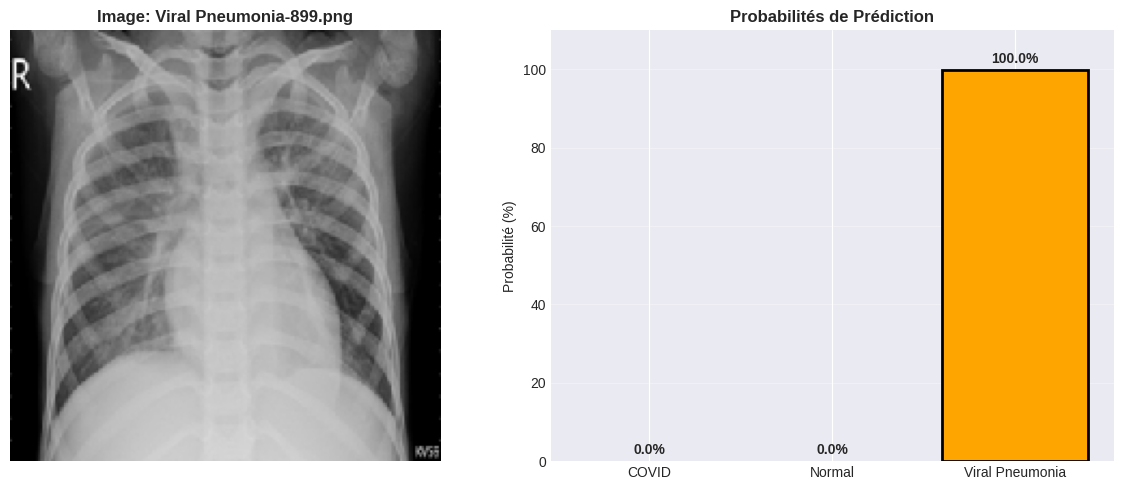


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: Viral Pneumonia-899.png
🎯 Prédiction: Viral Pneumonia
📈 Confiance: 99.99%

🔍 Détails:
  COVID: 0.01%
  Normal: 0.01%
  Viral Pneumonia: 99.99%

[3/5] Viral Pneumonia-476.png


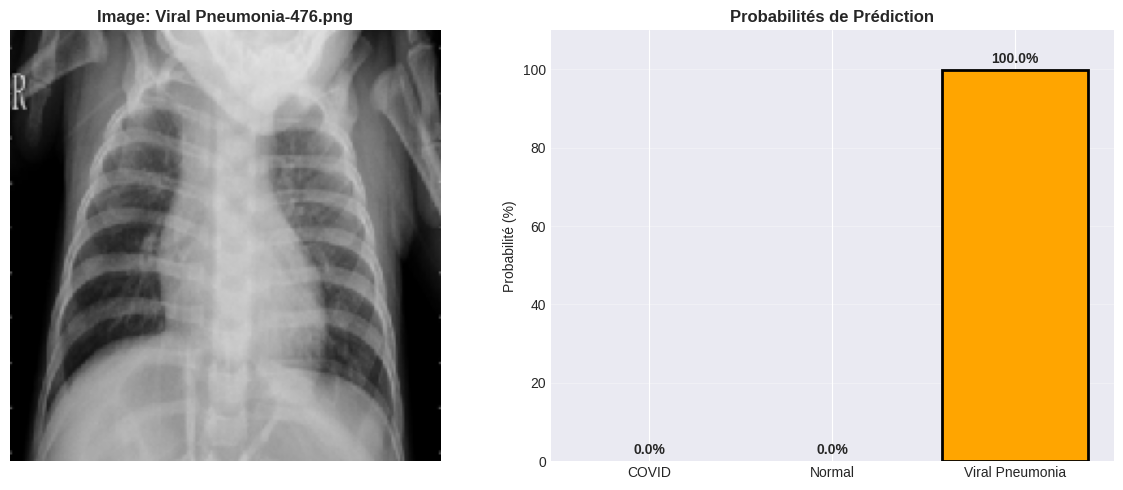


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: Viral Pneumonia-476.png
🎯 Prédiction: Viral Pneumonia
📈 Confiance: 100.00%

🔍 Détails:
  COVID: 0.00%
  Normal: 0.00%
  Viral Pneumonia: 100.00%

[4/5] Viral Pneumonia-733.png


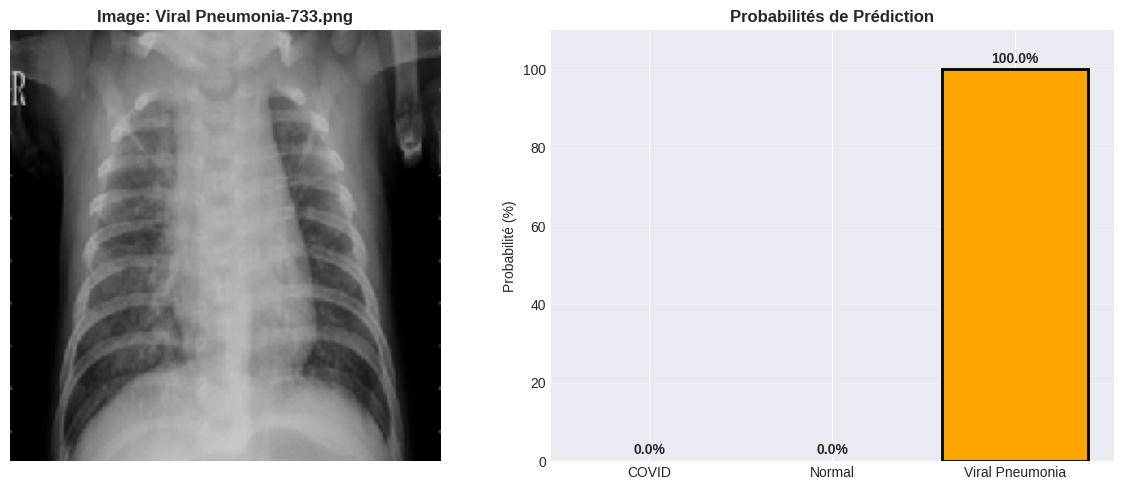


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: Viral Pneumonia-733.png
🎯 Prédiction: Viral Pneumonia
📈 Confiance: 100.00%

🔍 Détails:
  COVID: 0.00%
  Normal: 0.00%
  Viral Pneumonia: 100.00%

[5/5] Viral Pneumonia-158.png


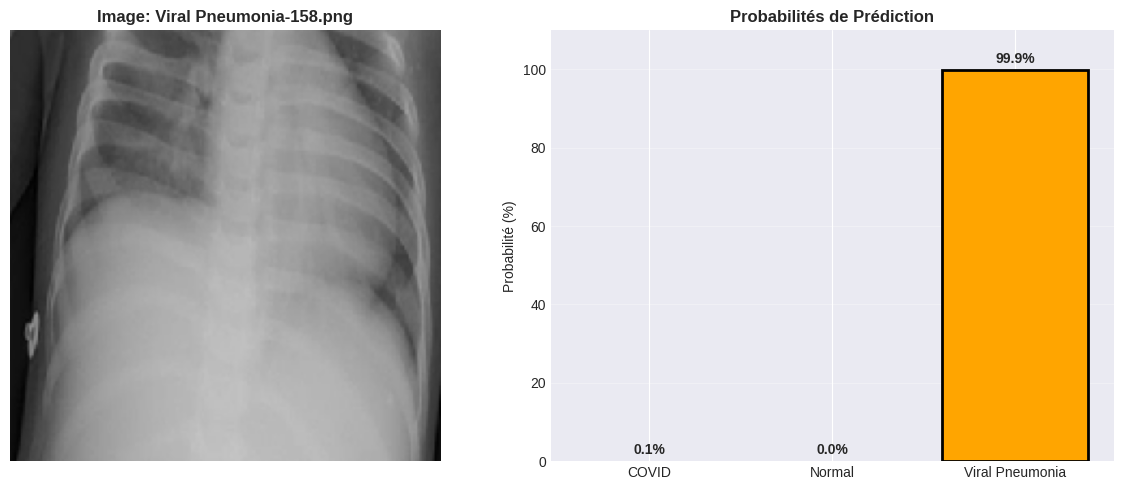


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: Viral Pneumonia-158.png
🎯 Prédiction: Viral Pneumonia
📈 Confiance: 99.92%

🔍 Détails:
  COVID: 0.07%
  Normal: 0.00%
  Viral Pneumonia: 99.92%

📈 RÉSUMÉ FINAL DES PRÉDICTIONS
COVID: 5 image(s)
Viral Pneumonia: 5 image(s)

📊 Confiance moyenne: 93.2%

🎲 TEST SUR UNE IMAGE ALÉATOIRE

🎲 Image aléatoire sélectionnée: Viral Pneumonia-391.png
📁 Dossier: Viral Pneumonia


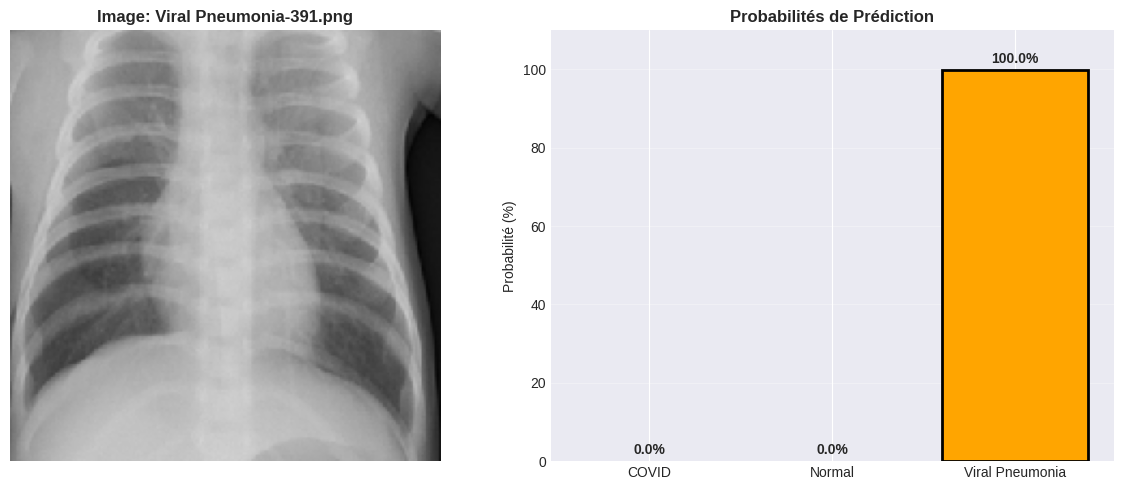


📊 RÉSULTATS DE LA PRÉDICTION
📁 Fichier: Viral Pneumonia-391.png
🎯 Prédiction: Viral Pneumonia
📈 Confiance: 100.00%

🔍 Détails:
  COVID: 0.00%
  Normal: 0.00%
  Viral Pneumonia: 100.00%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ========================
# 1. CHARGEMENT DU MODÈLE
# ========================
print("⚙️ Chargement du modèle...")
model_path = '/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.keras'
model = load_model(model_path)
print("✅ Modèle chargé avec succès!")

# Classes
classes = ['COVID', 'Normal', 'Viral Pneumonia']
class_colors = ['red', 'green', 'orange']

# ========================
# 2. FONCTION DE PRÉDICTION SIMPLE
# ========================
def predict_image(img_path):
    """
    Prédit une image et affiche les résultats
    """
    # Vérifier si le fichier existe
    if not os.path.exists(img_path):
        print(f"❌ Fichier non trouvé: {img_path}")
        return

    # Charger et prétraiter l'image
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Prédiction
    predictions = model.predict(img_array, verbose=0)[0]
    predicted_idx = np.argmax(predictions)
    predicted_class = classes[predicted_idx]
    confidence = predictions[predicted_idx] * 100

    # Affichage
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Image originale
    ax1.imshow(img)
    ax1.set_title(f'Image: {os.path.basename(img_path)}', fontweight='bold')
    ax1.axis('off')

    # Graphique des probabilités
    bars = ax2.bar(classes, predictions * 100, color=class_colors, alpha=0.7)
    ax2.set_title('Probabilités de Prédiction', fontweight='bold')
    ax2.set_ylabel('Probabilité (%)')
    ax2.set_ylim([0, 110])
    ax2.grid(True, alpha=0.3, axis='y')

    # Mettre en valeur la prédiction
    bars[predicted_idx].set_alpha(1.0)
    bars[predicted_idx].set_edgecolor('black')
    bars[predicted_idx].set_linewidth(2)

    # Ajouter les valeurs
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Afficher les résultats en texte
    print("\n" + "="*50)
    print("📊 RÉSULTATS DE LA PRÉDICTION")
    print("="*50)
    print(f"📁 Fichier: {os.path.basename(img_path)}")
    print(f"🎯 Prédiction: {predicted_class}")
    print(f"📈 Confiance: {confidence:.2f}%")
    print("\n🔍 Détails:")
    for i, class_name in enumerate(classes):
        prob = predictions[i] * 100
        print(f"  {class_name}: {prob:.2f}%")
    print("="*50)

    return predicted_class, confidence

# ========================
# 3. PRÉDICTIONS AUTOMATIQUES
# ========================
# Option A: Analyser une image spécifique (modifiez le chemin ici)
print("\n" + "="*50)
print("🧪 TEST AUTOMATIQUE SUR UNE IMAGE")
print("="*50)

# Modifiez ce chemin selon votre structure
test_image = "/content/drive/MyDrive/COVID_XRay_Project/test_images/test1.jpg"

# Si le fichier existe, faites la prédiction
if os.path.exists(test_image):
    print(f"🔍 Analyse de: {os.path.basename(test_image)}")
    predict_image(test_image)
else:
    print(f"⚠️  Fichier test non trouvé: {test_image}")
    print("\n📁 Liste des dossiers disponibles:")

    # Lister les dossiers disponibles
    base_path = "/content/drive/MyDrive/COVID_XRay_Project"
    if os.path.exists(base_path):
        for item in os.listdir(base_path):
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path):
                print(f"  📂 {item}/")
                # Lister quelques fichiers dans chaque dossier
                try:
                    files = os.listdir(item_path)[:3]
                    for file in files:
                        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            print(f"    📄 {file}")
                except:
                    pass
    else:
        print(f"  ❌ Dossier {base_path} non trouvé")

# ========================
# 4. ANALYSE D'UN DOSSIER COMPLET
# ========================
def analyze_folder(folder_path):
    """
    Analyse toutes les images d'un dossier
    """
    if not os.path.exists(folder_path):
        print(f"❌ Dossier non trouvé: {folder_path}")
        return []

    # Trouver toutes les images
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []

    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_files.append(os.path.join(folder_path, file))

    if not image_files:
        print(f"⚠️  Aucune image trouvée dans: {folder_path}")
        return []

    print(f"\n📁 Analyse du dossier: {os.path.basename(folder_path)}")
    print(f"📊 {len(image_files)} images trouvées")

    results = []

    # Analyser chaque image
    for i, img_file in enumerate(image_files[:5], 1):  # Limité à 5 images
        print(f"\n[{i}/{min(5, len(image_files))}] {os.path.basename(img_file)}")
        try:
            pred_class, confidence = predict_image(img_file)
            results.append({
                'file': os.path.basename(img_file),
                'prediction': pred_class,
                'confidence': confidence
            })
        except Exception as e:
            print(f"   ❌ Erreur: {str(e)}")

    return results

# ========================
# 5. TEST AUTOMATIQUE MULTIPLE
# ========================
print("\n" + "="*50)
print("📁 TEST AUTOMATIQUE SUR PLUSIEURS DOSSIERS")
print("="*50)

# Dossiers à analyser automatiquement
test_folders = [
    "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test/COVID",
    "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test/NORMAL",
    "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test/Viral Pneumonia"
]

all_results = []

for folder in test_folders:
    if os.path.exists(folder):
        print(f"\n🔍 Analyse du dossier: {os.path.basename(folder)}")
        results = analyze_folder(folder)
        all_results.extend(results)
    else:
        print(f"⚠️  Dossier non trouvé: {folder}")

# Résumé final
if all_results:
    print("\n" + "="*50)
    print("📈 RÉSUMÉ FINAL DES PRÉDICTIONS")
    print("="*50)

    from collections import Counter
    predictions = [r['prediction'] for r in all_results]
    counts = Counter(predictions)

    for class_name in classes:
        count = counts.get(class_name, 0)
        if count > 0:
            print(f"{class_name}: {count} image(s)")

    # Calculer la confiance moyenne
    avg_confidence = np.mean([r['confidence'] for r in all_results])
    print(f"\n📊 Confiance moyenne: {avg_confidence:.1f}%")

# ========================
# 6. FONCTION POUR UNE IMAGE ALÉATOIRE
# ========================
def predict_random_image():
    """
    Trouve et analyse une image aléatoire dans le dataset
    """
    import random

    # Chercher dans les sous-dossiers de test
    test_base = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

    if not os.path.exists(test_base):
        print(f"❌ Dossier test non trouvé: {test_base}")
        return

    # Trouver toutes les images
    all_images = []
    for root, dirs, files in os.walk(test_base):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_images.append(os.path.join(root, file))

    if not all_images:
        print("⚠️  Aucune image trouvée dans le dossier test")
        return

    # Choisir une image aléatoire
    random_image = random.choice(all_images)
    print(f"\n🎲 Image aléatoire sélectionnée: {os.path.basename(random_image)}")
    print(f"📁 Dossier: {os.path.dirname(random_image).split('/')[-1]}")

    # Faire la prédiction
    predict_image(random_image)

# Exécuter une prédiction aléatoire
print("\n" + "="*50)
print("🎲 TEST SUR UNE IMAGE ALÉATOIRE")
print("="*50)
predict_random_image()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

print("Train exists:", os.path.exists(train_dir))
print("Val exists:", os.path.exists(val_dir))
print("Test exists:", os.path.exists(test_dir))


Train exists: True
Val exists: True
Test exists: True


In [ ]:
classes = sorted(os.listdir(train_dir))
print("Classes détectées:", classes)


Classes détectées: ['COVID', 'Normal', 'Viral Pneumonia']


In [ ]:
class_indices = {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Charger le modèle
model = load_model('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.h5')

# Préparer le test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test",
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Évaluer
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy : {test_acc:.4f}")


Found 1517 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 317s 7s/step - accuracy: 0.8635 - loss: 0.3597
Test Accuracy : 0.9169


48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step


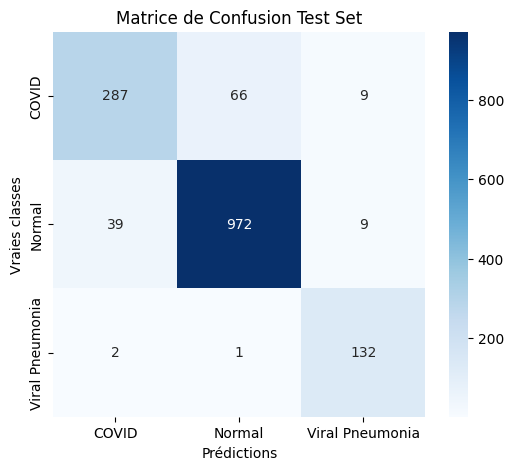

                 precision    recall  f1-score   support

          COVID       0.88      0.79      0.83       362
         Normal       0.94      0.95      0.94      1020
Viral Pneumonia       0.88      0.98      0.93       135

       accuracy                           0.92      1517
      macro avg       0.90      0.91      0.90      1517
   weighted avg       0.92      0.92      0.92      1517



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prédictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')
plt.title('Matrice de Confusion Test Set')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.h5')


In [ ]:
import shutil
import os

# Dossier local où copier les images
local_base = "/content/chest_xray"
os.makedirs(local_base, exist_ok=True)

# Dossiers Drive
drive_base = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray"
subfolders = ['train', 'val', 'test']

for folder in subfolders:
    src = os.path.join(drive_base, folder)
    dst = os.path.join(local_base, folder)
    if not os.path.exists(dst):
        shutil.copytree(src, dst)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import numpy as np
import os
import numpy as np

IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

# Liste de tous les fichiers et labels
file_paths = []
labels = []

for folder in ['train', 'val']:
    for cls in ['COVID', 'Normal', 'Viral Pneumonia']:
        path = os.path.join(local_base, folder, cls)
        for img_name in os.listdir(path):
            file_paths.append(os.path.join(path, img_name))
            labels.append(cls)

file_paths = np.array(file_paths)
labels = np.array(labels)

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
img = img_to_array(img).astype('float16') / 255.0


NameError: name 'img_to_array' is not defined

In [ ]:
X = np.load('X.npy', mmap_mode='r')  # mmap_mode permet de ne pas charger tout en RAM
y = np.load('y.npy', mmap_mode='r')


In [ ]:
print("Fichiers NumPy chargés avec mmap_mode='r', RAM minimale utilisée")
print("Nombre d'images :", X.shape[0])

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Classes
classes = ['COVID', 'Normal', 'Viral Pneumonia']

# Charger le modèle sauvegardé
model = load_model('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.h5')

# Charger les données NumPy (mode mmap pour RAM minimale)
X = np.load('X.npy', mmap_mode='r')
y = np.load('y.npy', mmap_mode='r')

print("Données chargées :", X.shape[0], "images")


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n========== Fold {fold} ==========")

    # Sélection du pli de validation
    X_val = X[val_idx]
    y_val = y[val_idx]

    # Prédictions du modèle sur ce pli
    Y_pred = model.predict(X_val, verbose=0)
    y_pred = np.argmax(Y_pred, axis=1)

    # Accuracy pour ce fold
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    # Matrice de confusion et classification report (optionnel)
    cm = confusion_matrix(y_val, y_pred)
    print("Matrice de confusion :")
    print(cm)
    print("\nClassification Report :")
    print(classification_report(y_val, y_pred, target_names=classes))


In [ ]:
print("\n===== Résultats Approximation 5-Fold CV =====")
print(f"Accuracy moyenne : {np.mean(fold_accuracies):.4f}")
print(f"Écart-type       : {np.std(fold_accuracies):.4f}")


In [ ]:
cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies classes')
    plt.title(f'Matrice de Confusion - Fold {fold}')
    plt.show()

    # Classification report
    print("\nClassification Report :")
    print(classification_report(y_val, y_pred, target_names=classes))